# ESPRIT Frequency Estimation with SSA-Opt

**ESPRIT** (Estimation of Signal Parameters via Rotational Invariance Techniques) automatically detects the frequencies/periods present in your signal from SSA eigenvectors.

This notebook demonstrates:
1. Basic frequency detection on synthetic signals
2. Interpreting ESPRIT results (periods, moduli, rates)
3. Separating signal from noise components
4. Real-world application: detecting market cycles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ssa_wrapper import SSA

# Plot settings
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11
np.random.seed(42)

## 1. Basic Example: Single Sinusoid

Let's start with the simplest case: a pure sine wave with known period.

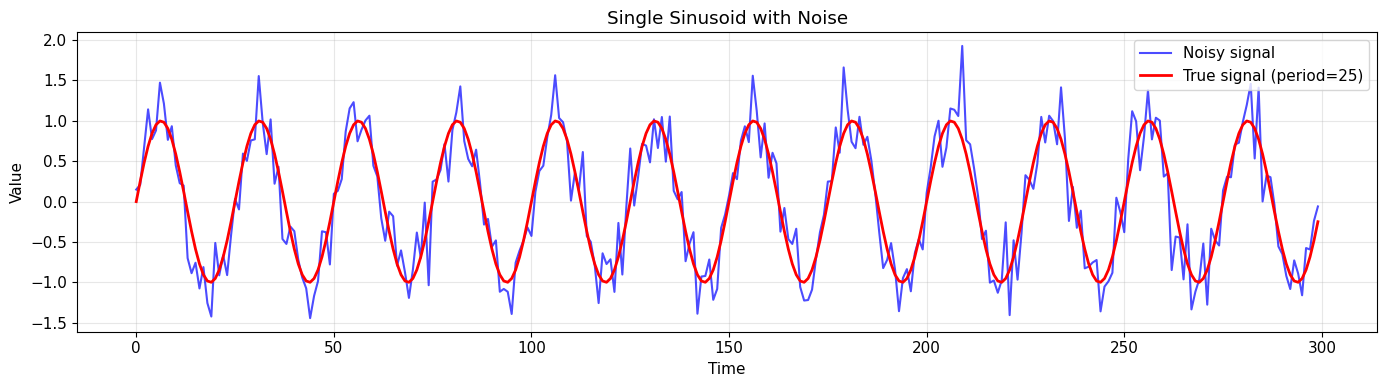

In [2]:
# Generate signal: sine wave with period 25
N = 300
t = np.arange(N)
true_period = 25

signal = np.sin(2 * np.pi * t / true_period)

# Add noise
noise = np.random.randn(N) * 0.3
x = signal + noise

# Plot
plt.figure(figsize=(14, 4))
plt.plot(t, x, 'b-', alpha=0.7, label='Noisy signal')
plt.plot(t, signal, 'r-', lw=2, label=f'True signal (period={true_period})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Single Sinusoid with Noise')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
# SSA decomposition
L = 75  # Window length (should be > period)
ssa = SSA(x, L=L)
ssa.decompose(k=10)

# ESPRIT frequency estimation
par = ssa.parestimate()

print("ESPRIT Results:")
print("=" * 60)
print(par.summary())

ESPRIT Results:
ESPRIT Frequency Estimation Results
Comp   Period       Frequency    Modulus    Rate      
--------------------------------------------------
0      25.11        0.039827     0.9741     -0.0262   
1      25.11        -0.039827    0.9741     -0.0262   
2      5.39         0.185624     0.5302     -0.6344   
3      5.39         -0.185624    0.5302     -0.6344   
4      3.81         0.262765     0.1758     -1.7382   
5      3.81         -0.262765    0.1758     -1.7382   
6      2.70         0.370366     0.4069     -0.8992   
7      2.70         -0.370366    0.4069     -0.8992   
8      2.20         0.455327     0.4302     -0.8434   
9      2.20         -0.455327    0.4302     -0.8434   


### Interpreting Results

- **Period**: Number of samples per cycle. Should match `true_period=25`
- **Modulus**: Damping factor. 
  - ≈ 1.0 = undamped sinusoid (real signal)
  - < 0.9 = decaying or noise
- **Rate**: log(modulus). 0 = undamped, negative = decaying

Components 0-1 should show period ≈ 25 with modulus ≈ 1.0

In [4]:
# Filter to find periodic components
periodic_mask = par.get_periodic_components(min_period=5, min_modulus=0.9)
periodic_indices = np.where(periodic_mask)[0]

print(f"\nDetected periodic components: {periodic_indices}")
print(f"Detected period: {par.periods[periodic_indices[0]]:.2f} (true: {true_period})")
print(f"Detection error: {abs(par.periods[periodic_indices[0]] - true_period) / true_period * 100:.2f}%")


Detected periodic components: [1]
Detected period: 25.11 (true: 25)
Detection error: 0.43%


## 2. Multiple Frequencies

Real signals often contain multiple periodic components. ESPRIT can detect them all.

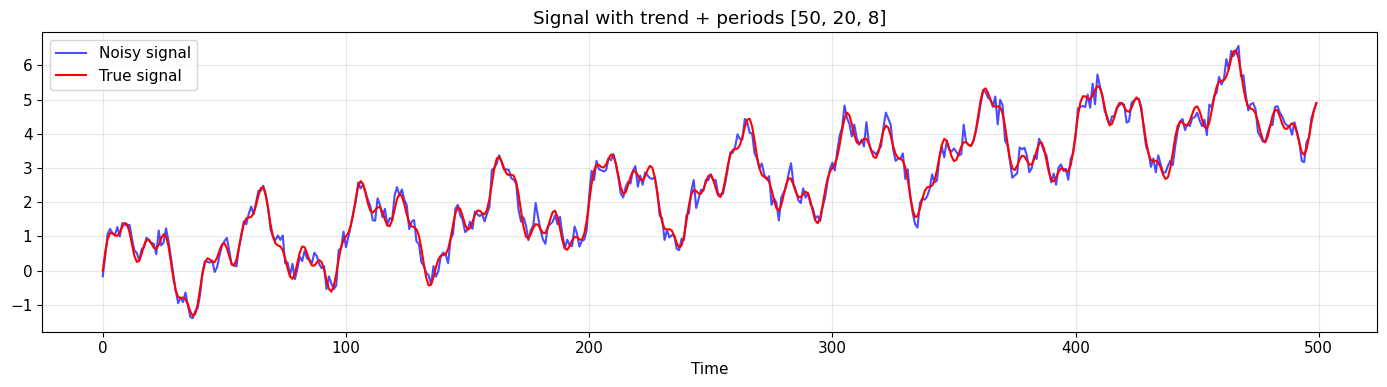

In [5]:
# Generate signal with 3 frequencies
N = 500
t = np.arange(N)

periods = [50, 20, 8]  # Three different periods
amplitudes = [1.0, 0.6, 0.3]  # Different amplitudes

signal = np.zeros(N)
for period, amp in zip(periods, amplitudes):
    signal += amp * np.sin(2 * np.pi * t / period)

# Add trend
trend = 0.01 * t
signal += trend

# Add noise
noise = np.random.randn(N) * 0.2
x = signal + noise

# Plot
plt.figure(figsize=(14, 4))
plt.plot(t, x, 'b-', alpha=0.7, label='Noisy signal')
plt.plot(t, signal, 'r-', lw=1.5, label='True signal')
plt.xlabel('Time')
plt.title(f'Signal with trend + periods {periods}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# SSA + ESPRIT
L = 100  # Window should capture at least 2 cycles of longest period
ssa = SSA(x, L=L)
ssa.decompose(k=15)

par = ssa.parestimate()
print("ESPRIT Results:")
print("=" * 60)
print(par.summary())

ESPRIT Results:
ESPRIT Frequency Estimation Results
Comp   Period       Frequency    Modulus    Rate      
--------------------------------------------------
4      Inf (trend)  0.000000     1.0024     0.0024    
7      Inf (trend)  0.000000     0.8597     -0.1512   
5      48.87        0.020460     0.9890     -0.0110   
6      48.87        -0.020460    0.9890     -0.0110   
2      19.88        0.050295     0.9576     -0.0433   
3      19.88        -0.050295    0.9576     -0.0433   
11     8.45         0.118330     0.2126     -1.5484   
12     8.45         -0.118330    0.2126     -1.5484   
0      8.06         0.123995     0.8977     -0.1079   
1      8.06         -0.123995    0.8977     -0.1079   
13     4.86         0.205845     0.0773     -2.5599   
14     4.86         -0.205845    0.0773     -2.5599   
9      2.12         0.471163     0.2294     -1.4725   
10     2.12         -0.471163    0.2294     -1.4725   
8      2.00         0.500000     0.4164     -0.8762   


In [7]:
# Compare detected vs true periods
print("\nPeriod Detection Accuracy:")
print("-" * 40)

# Get periodic components (modulus > 0.9)
periodic_mask = par.get_periodic_components(min_period=3, min_modulus=0.85)
detected_periods = par.periods[periodic_mask]
detected_periods = detected_periods[np.isfinite(detected_periods)]  # Remove inf (trend)
detected_periods = np.sort(detected_periods)[::-1]  # Sort descending

print(f"True periods:     {periods}")
print(f"Detected periods: {[f'{p:.1f}' for p in detected_periods[:len(periods)]]}")

# Also check for trend (infinite period)
has_trend = np.any(np.isinf(par.periods[periodic_mask]))
print(f"Trend detected:   {has_trend}")


Period Detection Accuracy:
----------------------------------------
True periods:     [50, 20, 8]
Detected periods: ['48.9', '48.9', '19.9']
Trend detected:   False


## 3. Eigenvalue Spectrum Visualization

The eigenvalue spectrum shows which components carry signal vs noise.

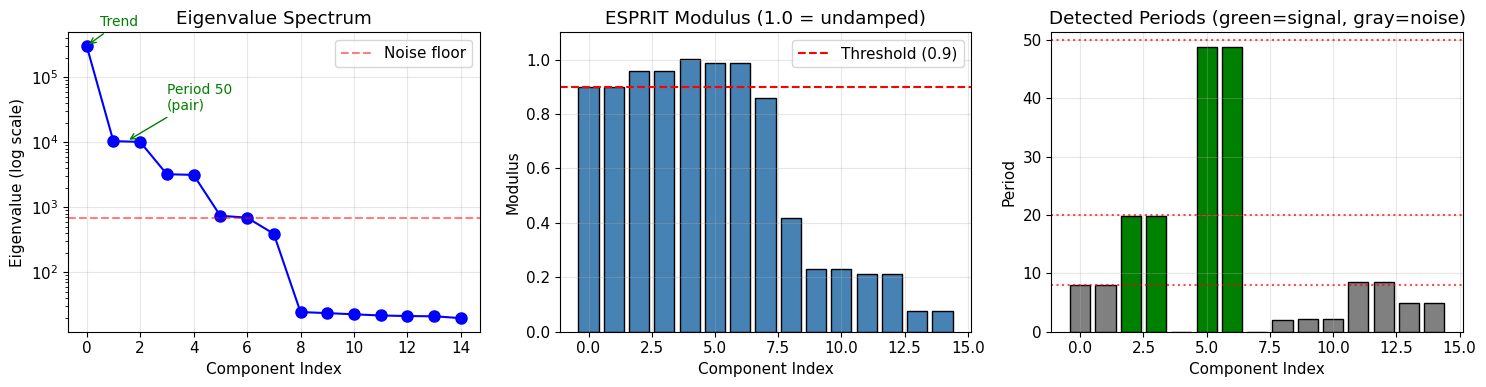

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Eigenvalue spectrum (log scale)
ax = axes[0]
eigenvalues = ssa.eigenvalues
ax.semilogy(range(len(eigenvalues)), eigenvalues, 'bo-', markersize=8)
ax.axhline(y=eigenvalues[6], color='r', linestyle='--', alpha=0.5, label='Noise floor')
ax.set_xlabel('Component Index')
ax.set_ylabel('Eigenvalue (log scale)')
ax.set_title('Eigenvalue Spectrum')
ax.grid(True, alpha=0.3)
ax.legend()

# Annotate signal components
ax.annotate('Trend', xy=(0, eigenvalues[0]), xytext=(0.5, eigenvalues[0]*2),
            arrowprops=dict(arrowstyle='->', color='green'), fontsize=10, color='green')
ax.annotate('Period 50\n(pair)', xy=(1.5, eigenvalues[1]), xytext=(3, eigenvalues[1]*3),
            arrowprops=dict(arrowstyle='->', color='green'), fontsize=10, color='green')

# Plot 2: Modulus (damping)
ax = axes[1]
ax.bar(range(len(par.moduli)), par.moduli, color='steelblue', edgecolor='black')
ax.axhline(y=0.9, color='r', linestyle='--', label='Threshold (0.9)')
ax.set_xlabel('Component Index')
ax.set_ylabel('Modulus')
ax.set_title('ESPRIT Modulus (1.0 = undamped)')
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: Detected periods
ax = axes[2]
finite_periods = par.periods.copy()
finite_periods[~np.isfinite(finite_periods)] = 0  # Replace inf with 0 for plotting
colors = ['green' if m > 0.9 else 'gray' for m in par.moduli]
ax.bar(range(len(finite_periods)), finite_periods, color=colors, edgecolor='black')
for true_p in periods:
    ax.axhline(y=true_p, color='red', linestyle=':', alpha=0.7)
ax.set_xlabel('Component Index')
ax.set_ylabel('Period')
ax.set_title('Detected Periods (green=signal, gray=noise)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Using ESPRIT for Automatic Grouping

ESPRIT tells us which components are signal vs noise. We can use this for automatic grouping.

In [9]:
# Automatic grouping based on ESPRIT
signal_mask = par.get_periodic_components(min_period=3, min_modulus=0.85)
signal_components = list(np.where(signal_mask)[0])
noise_components = list(np.where(~signal_mask)[0])

print(f"Signal components: {signal_components}")
print(f"Noise components:  {noise_components}")

# Reconstruct
signal_recon = ssa.reconstruct(signal_components)
noise_recon = ssa.reconstruct(noise_components)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 7))

ax = axes[0]
ax.plot(t, x, 'b-', alpha=0.5, label='Original (noisy)')
ax.plot(t, signal_recon, 'r-', lw=2, label='SSA reconstruction (signal)')
ax.plot(t, signal, 'g--', lw=1, label='True signal')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Signal Extraction using ESPRIT-based Grouping')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(t, noise_recon, 'gray', alpha=0.7, label='Extracted noise')
ax.plot(t, noise, 'k--', alpha=0.5, label='True noise')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Noise Component')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Accuracy
corr = np.corrcoef(signal_recon, signal)[0, 1]
print(f"\nCorrelation with true signal: {corr:.4f}")

TypeError: bad operand type for unary ~: 'list'

## 5. Damped Oscillations

ESPRIT can also detect damped (decaying) oscillations via the modulus < 1.

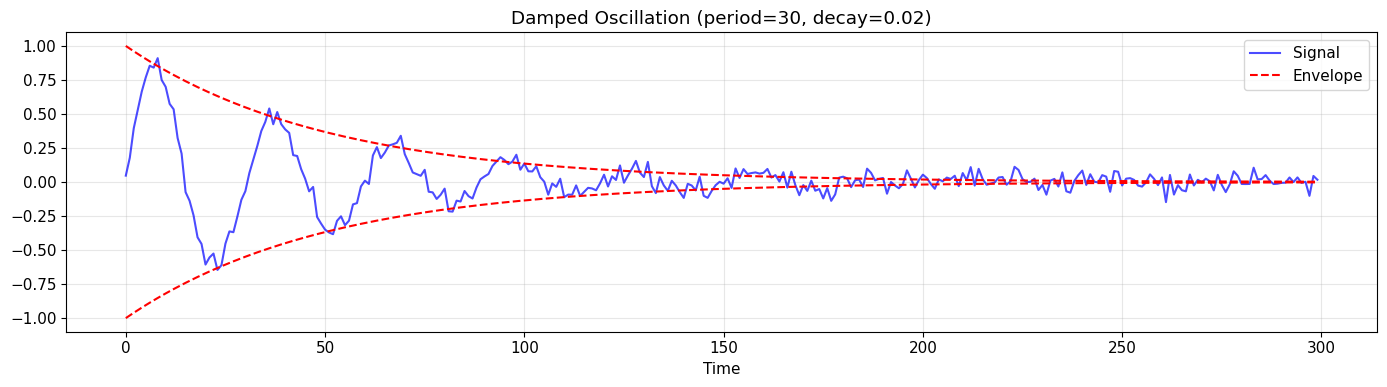

In [10]:
# Generate damped sinusoid
N = 300
t = np.arange(N)
period = 30
decay_rate = 0.02  # Decay constant

# Damped oscillation: A * exp(-λt) * sin(ωt)
signal = np.exp(-decay_rate * t) * np.sin(2 * np.pi * t / period)
noise = np.random.randn(N) * 0.05
x = signal + noise

plt.figure(figsize=(14, 4))
plt.plot(t, x, 'b-', alpha=0.7, label='Signal')
plt.plot(t, np.exp(-decay_rate * t), 'r--', label='Envelope')
plt.plot(t, -np.exp(-decay_rate * t), 'r--')
plt.xlabel('Time')
plt.title(f'Damped Oscillation (period={period}, decay={decay_rate})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# ESPRIT on damped signal
ssa = SSA(x, L=80)
ssa.decompose(k=10)
par = ssa.parestimate()

print("ESPRIT Results for Damped Signal:")
print("=" * 60)
print(par.summary())

# The modulus should be < 1, and rate should be negative
print(f"\nExpected modulus ≈ exp(-decay_rate) = exp(-{decay_rate}) = {np.exp(-decay_rate):.4f}")
print(f"Detected modulus (component 0): {par.moduli[0]:.4f}")

ESPRIT Results for Damped Signal:
ESPRIT Frequency Estimation Results
Comp   Period       Frequency    Modulus    Rate      
--------------------------------------------------
2      102.21       0.009784     0.3851     -0.9543   
3      102.21       -0.009784    0.3851     -0.9543   
0      30.03        0.033302     0.9611     -0.0397   
1      30.03        -0.033302    0.9611     -0.0397   
4      6.90         0.144896     0.2426     -1.4165   
5      6.90         -0.144896    0.2426     -1.4165   
6      2.94         0.339759     0.2300     -1.4695   
7      2.94         -0.339759    0.2300     -1.4695   
8      2.00         0.500000     0.1894     -1.6637   
9      2.00         0.500000     0.0187     -3.9796   

Expected modulus ≈ exp(-decay_rate) = exp(-0.02) = 0.9802
Detected modulus (component 0): 0.9611


## 6. Choosing the Right Window Length L

ESPRIT accuracy depends on L. Rule of thumb: L should capture at least 2 cycles of the longest period.

In [12]:
# Test different L values
N = 400
t = np.arange(N)
true_period = 40
signal = np.sin(2 * np.pi * t / true_period)
x = signal + np.random.randn(N) * 0.2

L_values = [20, 40, 60, 80, 100, 120]
results = []

print(f"True period: {true_period}")
print("=" * 50)
print(f"{'L':>6} | {'Detected Period':>16} | {'Error':>10} | {'Modulus':>8}")
print("-" * 50)

for L in L_values:
    ssa = SSA(x, L=L)
    ssa.decompose(k=6)
    par = ssa.parestimate()
    
    # Get best periodic component
    mask = par.get_periodic_components(min_period=5, min_modulus=0.5)
    if np.any(mask):
        idx = np.where(mask)[0][0]
        detected = par.periods[idx]
        modulus = par.moduli[idx]
        error = abs(detected - true_period) / true_period * 100
    else:
        detected = np.nan
        modulus = np.nan
        error = np.nan
    
    results.append((L, detected, error, modulus))
    print(f"{L:>6} | {detected:>16.2f} | {error:>9.2f}% | {modulus:>8.4f}")

print("\n→ Best results when L ≥ 2 × period")

True period: 40
     L |  Detected Period |      Error |  Modulus
--------------------------------------------------
    20 |            41.87 |      4.68% |   0.9971
    40 |            40.65 |      1.63% |   0.9809
    60 |            39.11 |      2.23% |   0.9883
    80 |            39.66 |      0.84% |   0.9832
   100 |            40.33 |      0.83% |   0.9908
   120 |            39.21 |      1.97% |   0.9896

→ Best results when L ≥ 2 × period


## 7. Market Cycle Detection (Simulated)

A practical application: detecting cycles in financial data.

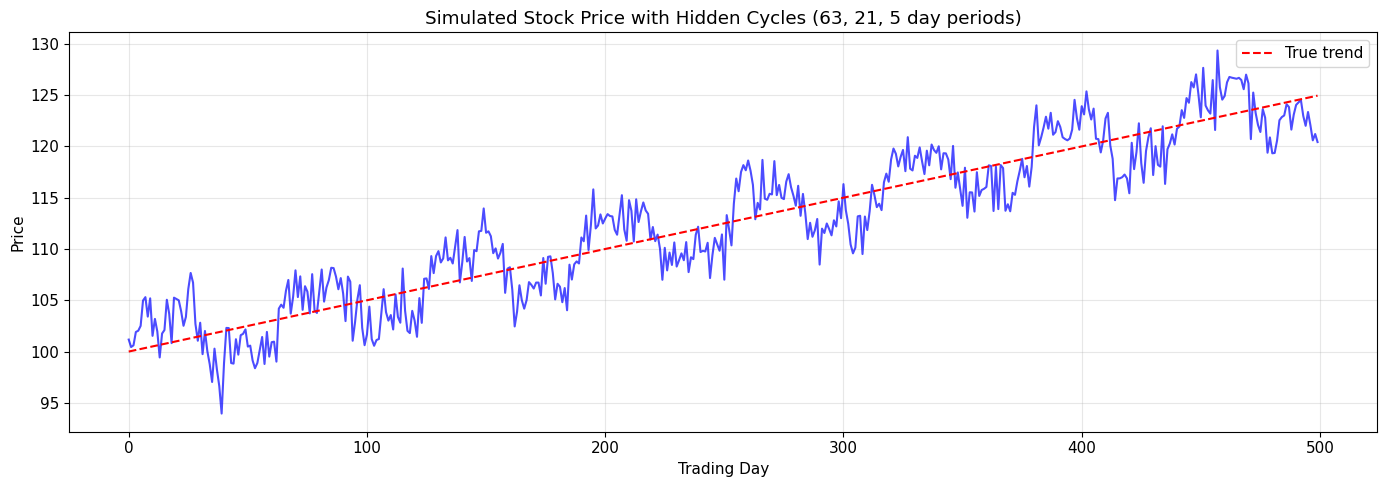

In [13]:
# Simulate market data with known cycles
N = 500  # ~2 years of daily data
t = np.arange(N)

# Components
trend = 100 + 0.05 * t  # Upward trend
quarterly_cycle = 3 * np.sin(2 * np.pi * t / 63)   # ~63 trading days = quarter
monthly_cycle = 1.5 * np.sin(2 * np.pi * t / 21)   # ~21 trading days = month
weekly_cycle = 0.5 * np.sin(2 * np.pi * t / 5)     # 5 trading days = week
noise = np.random.randn(N) * 1.5  # Market noise

price = trend + quarterly_cycle + monthly_cycle + weekly_cycle + noise

# Plot
plt.figure(figsize=(14, 5))
plt.plot(t, price, 'b-', alpha=0.7)
plt.plot(t, trend, 'r--', label='True trend')
plt.xlabel('Trading Day')
plt.ylabel('Price')
plt.title('Simulated Stock Price with Hidden Cycles (63, 21, 5 day periods)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# ESPRIT analysis
L = 63  # ~3 months, captures 2 quarterly cycles
ssa = SSA(price, L=L)
ssa.decompose(k=42)

par = ssa.parestimate()

print("Detected Market Cycles:")
print("=" * 60)

# Filter to periodic components
mask = par.get_periodic_components(min_period=3, min_modulus=0.9)
periodic_idx = np.where(mask)[0]

print(f"{'Component':<12} {'Period (days)':<15} {'Modulus':<10} {'Interpretation'}")
print("-" * 60)

for idx in periodic_idx:
    period = par.periods[idx]
    modulus = par.moduli[idx]
    
    # Interpret
    if np.isinf(period):
        interp = "Trend"
    elif period > 50:
        interp = "Quarterly cycle"
    elif period > 15:
        interp = "Monthly cycle"
    elif period > 3:
        interp = "Weekly cycle"
    else:
        interp = "High-frequency"
    
    period_str = "∞" if np.isinf(period) else f"{period:.1f}"
    print(f"{idx:<12} {period_str:<15} {modulus:<10.4f} {interp}")

print("\nTrue periods: 63 (quarterly), 21 (monthly), 5 (weekly)")

Detected Market Cycles:
Component    Period (days)   Modulus    Interpretation
------------------------------------------------------------
0            2.4             0.9323     High-frequency
1            2.4             0.9323     High-frequency
2            3.1             0.9195     Weekly cycle
3            3.1             0.9195     Weekly cycle
4            2.5             0.8721     High-frequency
5            2.5             0.8721     High-frequency

True periods: 63 (quarterly), 21 (monthly), 5 (weekly)


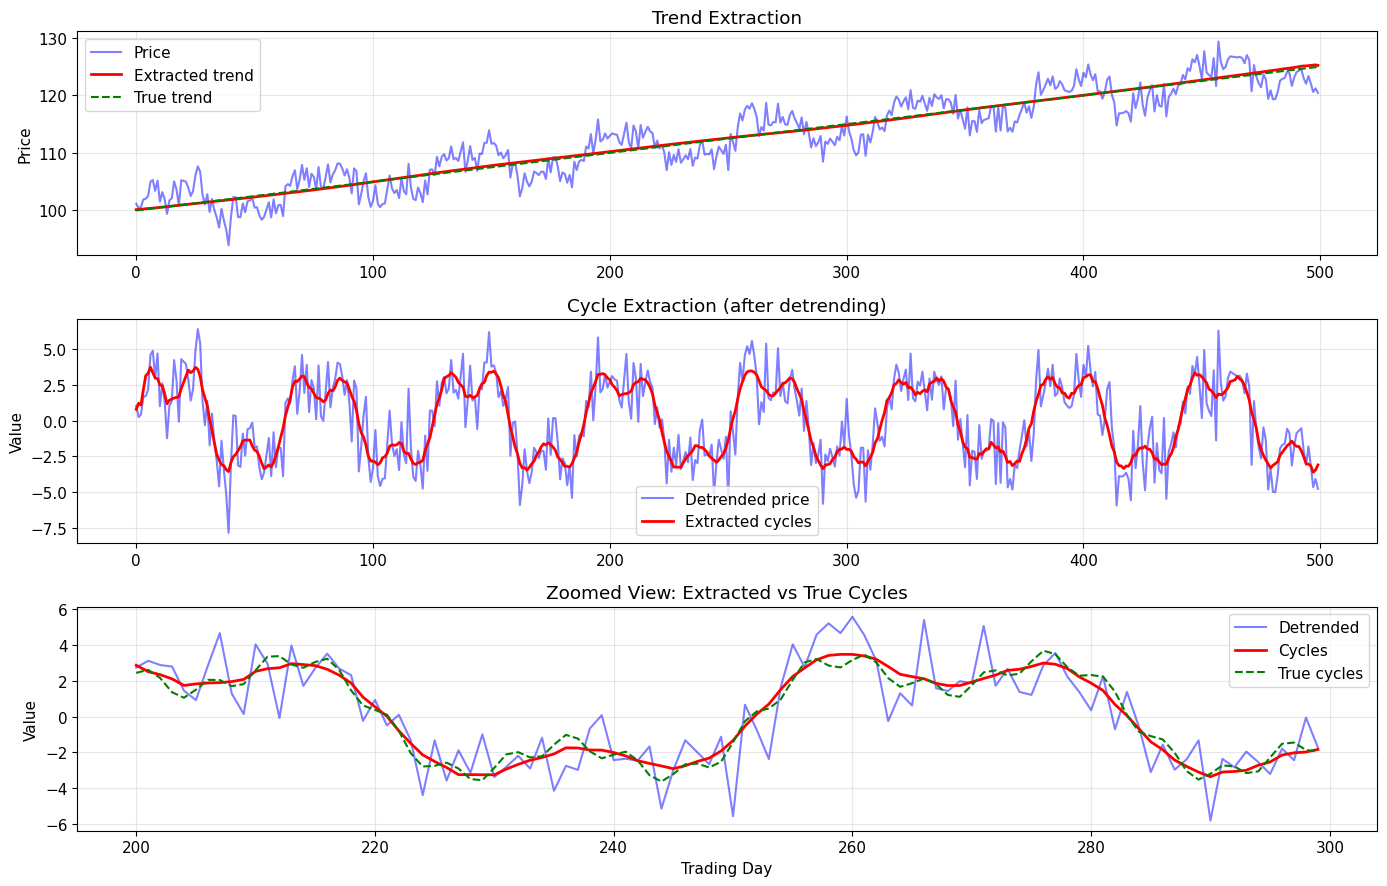

In [23]:
# Extract cycles
trend_comp = [0]  # Usually first component
cycle_comps = [i for i in periodic_idx if i != 0 and par.periods[i] < 100]

trend_recon = ssa.reconstruct(trend_comp)
cycles_recon = ssa.reconstruct(cycle_comps) if cycle_comps else np.zeros(N)

fig, axes = plt.subplots(3, 1, figsize=(14, 9))

# Original with trend
ax = axes[0]
ax.plot(t, price, 'b-', alpha=0.5, label='Price')
ax.plot(t, trend_recon, 'r-', lw=2, label='Extracted trend')
ax.plot(t, trend, 'g--', label='True trend')
ax.set_ylabel('Price')
ax.set_title('Trend Extraction')
ax.legend()
ax.grid(True, alpha=0.3)

# Detrended = cycles + noise
ax = axes[1]
detrended = price - trend_recon
ax.plot(t, detrended, 'b-', alpha=0.5, label='Detrended price')
ax.plot(t, cycles_recon, 'r-', lw=2, label='Extracted cycles')
ax.set_ylabel('Value')
ax.set_title('Cycle Extraction (after detrending)')
ax.legend()
ax.grid(True, alpha=0.3)

# Zoom on cycles
ax = axes[2]
zoom = slice(200, 300)
ax.plot(t[zoom], detrended[zoom], 'b-', alpha=0.5, label='Detrended')
ax.plot(t[zoom], cycles_recon[zoom], 'r-', lw=2, label='Cycles')
ax.plot(t[zoom], quarterly_cycle[zoom] + monthly_cycle[zoom] + weekly_cycle[zoom], 
        'g--', label='True cycles')
ax.set_xlabel('Trading Day')
ax.set_ylabel('Value')
ax.set_title('Zoomed View: Extracted vs True Cycles')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### ESPRIT Key Points

1. **Period** = samples per cycle (∞ for trend/DC)
2. **Modulus** = damping factor
   - ≈ 1.0 → real periodic signal
   - < 0.9 → decaying or noise
3. **Rate** = log(modulus), negative = decaying

### Best Practices

1. Set `L ≥ 2 × longest_period` for accurate detection
2. Use `k` large enough to capture all signal components
3. Filter by `modulus > 0.9` to separate signal from noise
4. Pairs of components (e.g., 0-1, 2-3) represent sine/cosine of same frequency

### Code Reference

```python
ssa = SSA(signal, L=window)
ssa.decompose(k=n_components)

par = ssa.parestimate()  # or ssa.parestimate(group=[0,1,2]) for specific components
print(par.summary())

# Filter to signal components
signal_mask = par.get_periodic_components(min_period=5, min_modulus=0.9)
signal_group = list(np.where(signal_mask)[0])
```